In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind

In [8]:
crime_data = pd.read_csv('./crime-housing-austin-2015.csv')
zip_code_data = pd.read_csv('./AustinZipCodes.csv')

zip_code_data['Population'] = zip_code_data['Population'].str.replace(',', '').astype(int)
zip_code_data['People / Sq. Mile'] = zip_code_data['People / Sq. Mile'].str.replace(',', '').astype(float)

crime_data['crimes'] = 0
crime_data['Cleared_by_arrest'] = crime_data['Clearance_Status'] == 'C'
crime_data['Cleared_by_exception'] = crime_data['Clearance_Status'] == 'O'
crime_data['Not_cleared'] = crime_data['Clearance_Status'] == 'N'

crime_data = pd.merge(
	crime_data,
	zip_code_data,
	how='left',
	left_on='Zip_Code_Crime',
	right_on='Zip Code'
).reset_index()

violent_crimes = ['Robbery', 'Agg Assault', 'Rape', 'Murder']

crime_data['Violent'] = crime_data.Highest_NIBRS_UCR_Offense_Description.isin(violent_crimes)

grouped_by_zip_code = crime_data.groupby('Zip_Code_Crime')

crime_data_by_zip_code = grouped_by_zip_code.agg({
	'Populationbelowpovertylevel': 'first',
	'Medianhouseholdincome': 'first',
	'Populationwithdisability': 'first',
	'Unemployment': 'first',
	'Medianrent': 'first',
	'Medianhomevalue': 'first',
	'Percentageofhomeswithin1/4-mioftransitstop': 'first',
	'crimes': 'count',
	'Cleared_by_arrest': 'sum',
	'Cleared_by_exception': 'sum',
	'Not_cleared': 'sum',
	'Population': 'first',
	'Violent': 'sum'
}).dropna().reset_index()

crime_data_by_zip_code['clearance_rate'] = (
	crime_data_by_zip_code['Cleared_by_arrest'] + crime_data_by_zip_code['Cleared_by_exception']
) / crime_data_by_zip_code['crimes']

fake_number_columns = [
	'Populationbelowpovertylevel',
	'Percentageofhomeswithin1/4-mioftransitstop',
	'Medianhouseholdincome',
	'Populationwithdisability',
	'Unemployment',
	'Medianrent',
	'Medianhomevalue'
]

percent_columns = [
	'Populationbelowpovertylevel',
	'Populationwithdisability',
	'Unemployment'
]

for column in fake_number_columns:
	crime_data_by_zip_code[column] = crime_data_by_zip_code[column].str.extract('(\d+)').astype(int)

for column in percent_columns:
	crime_data_by_zip_code[column] = crime_data_by_zip_code[column] / 100

crime_data_by_zip_code['Crimes per capita'] = crime_data_by_zip_code.crimes / crime_data_by_zip_code.Population
# Pull out the outlier
crime_data_by_zip_code = crime_data_by_zip_code[crime_data_by_zip_code['Crimes per capita'] < 0.3]



# Household Income to Per Capita Crime Rate

PearsonRResult(statistic=-0.6583575925756772, pvalue=2.3126276203441827e-05)

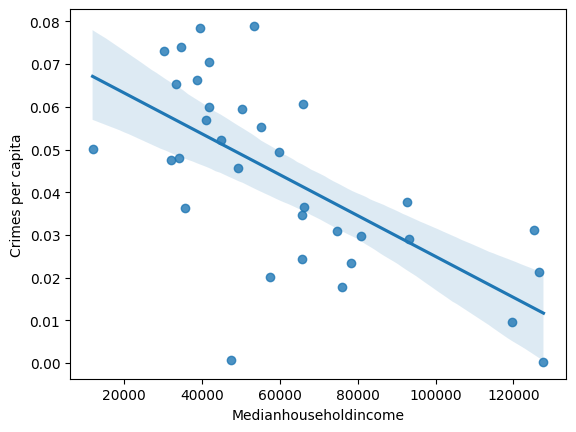

In [9]:
display(stats.pearsonr(crime_data_by_zip_code.Medianhouseholdincome, crime_data_by_zip_code['Crimes per capita']))

sns.regplot(crime_data_by_zip_code, x='Medianhouseholdincome', y='Crimes per capita')

higher_household_incomes = crime_data_by_zip_code[crime_data_by_zip_code.Medianhouseholdincome > 54215]
lower_household_incomes = crime_data_by_zip_code[crime_data_by_zip_code.Medianhouseholdincome <= 54215]

# Homes Within a Quarter Mile of a Transit Stop to Per Capita Crime Rate

PearsonRResult(statistic=0.6628127272009937, pvalue=1.9451267356078564e-05)

PearsonRResult(statistic=0.4266739774592966, pvalue=0.011854127570620107)

PearsonRResult(statistic=0.18811194225464387, pvalue=0.28669883036495253)

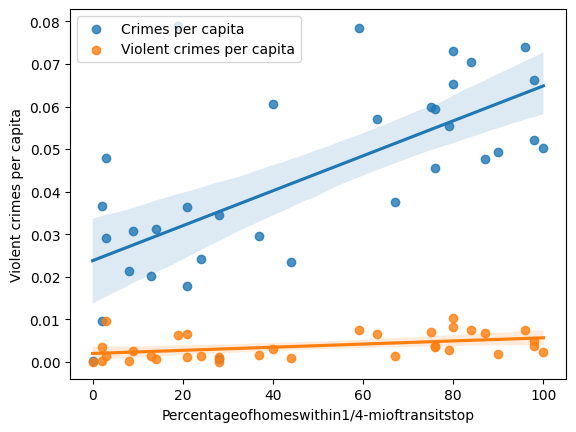

In [10]:
violent_crime_data = crime_data_by_zip_code.copy()

violent_crime_data['percent_violent'] = violent_crime_data.Violent / violent_crime_data.crimes * 100

display(stats.pearsonr(violent_crime_data['Percentageofhomeswithin1/4-mioftransitstop'], violent_crime_data['Crimes per capita']))

sns.regplot(violent_crime_data, x='Percentageofhomeswithin1/4-mioftransitstop', y='Crimes per capita', label='Crimes per capita')

violent_crime_data['Violent crimes per capita'] = violent_crime_data.Violent / violent_crime_data.Population

display(stats.pearsonr(violent_crime_data['Percentageofhomeswithin1/4-mioftransitstop'], violent_crime_data['Violent crimes per capita']))

sns.regplot(violent_crime_data, x='Percentageofhomeswithin1/4-mioftransitstop', y='Violent crimes per capita', label='Violent crimes per capita')

plt.legend()

display(stats.pearsonr(violent_crime_data['Percentageofhomeswithin1/4-mioftransitstop'], violent_crime_data.percent_violent))

# Unemployment Rate to Per Capita Crime Rate

Crime Rate Mean: 0.043403398060387496
Unemployment Rate Mean: 0.07205882352941177
Crime Rate Standard Deviation: 0.02172624097342629
Unemployment Rate Standard Deviation: 0.030429193694164906

T-statistic: -4.468874022899825
P-value: 3.1608465384074884e-05


PearsonRResult(statistic=0.5707757583912579, pvalue=0.00042350726376412826)

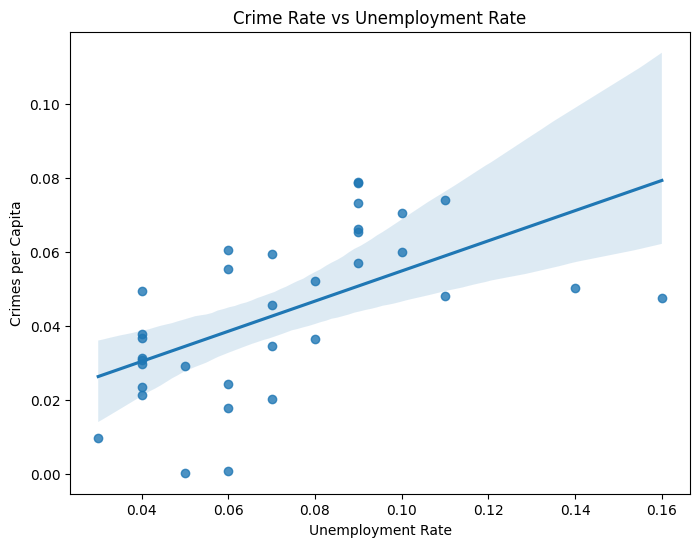

In [11]:
# Calculate means and standard deviations
crime_mean = crime_data_by_zip_code['Crimes per capita'].mean()
unemployment_mean = crime_data_by_zip_code['Unemployment'].mean()
crime_std = crime_data_by_zip_code['Crimes per capita'].std()
unemployment_std = crime_data_by_zip_code['Unemployment'].std()

# Print means and standard deviations
print("Crime Rate Mean:", crime_mean)
print("Unemployment Rate Mean:", unemployment_mean)
print("Crime Rate Standard Deviation:", crime_std)
print("Unemployment Rate Standard Deviation:", unemployment_std)

# Calculate t-test
t_stat, p_value = ttest_ind(crime_data_by_zip_code['Crimes per capita'], crime_data_by_zip_code['Unemployment'])

# Print results
print("\nT-statistic:", t_stat)
print("P-value:", p_value)

display(stats.pearsonr(crime_data_by_zip_code['Crimes per capita'], crime_data_by_zip_code['Unemployment']))


# Data visualization
plt.figure(figsize=(8, 6))
sns.regplot(data=crime_data_by_zip_code, x='Unemployment', y='Crimes per capita')
plt.title('Crime Rate vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Crimes per Capita')
plt.show()

# Population Below Poverty Level to Per Capita Crime Rate

Crime Rate Mean: 0.043403398060387496
Population Below Poverty Level Mean: 0.18029411764705885
Crime Rate Standard Deviation: 0.02172624097342629
Population Below Poverty Level Standard Deviation: 0.14322022233456244

T-statistic: -5.510216823244732
P-value: 6.373093062820474e-07


PearsonRResult(statistic=0.5529362259948573, pvalue=0.000695385785066734)

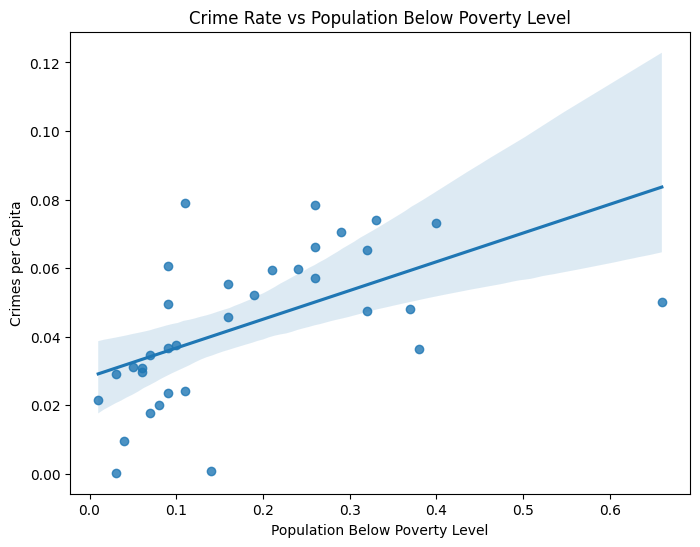

In [12]:
# Calculate means and standard deviations
pop_below_pov_mean = crime_data_by_zip_code['Populationbelowpovertylevel'].mean()
pop_below_pov_std = crime_data_by_zip_code['Populationbelowpovertylevel'].std()

# Print means and standard deviations
print("Crime Rate Mean:", crime_mean)
print("Population Below Poverty Level Mean:", pop_below_pov_mean)
print("Crime Rate Standard Deviation:", crime_std)
print("Population Below Poverty Level Standard Deviation:", pop_below_pov_std)

# Calculate t-test
t_stat, p_value = ttest_ind(crime_data_by_zip_code['Crimes per capita'], crime_data_by_zip_code['Populationbelowpovertylevel'])

# Print results
print("\nT-statistic:", t_stat)
print("P-value:", p_value)
display(stats.pearsonr(crime_data_by_zip_code['Crimes per capita'], crime_data_by_zip_code['Populationbelowpovertylevel']))

# Data visualization
plt.figure(figsize=(8, 6))
sns.regplot(data=crime_data_by_zip_code, x='Populationbelowpovertylevel', y='Crimes per capita')
plt.title('Crime Rate vs Population Below Poverty Level')
plt.xlabel('Population Below Poverty Level')
plt.ylabel('Crimes per Capita')
plt.show()